<a href="https://colab.research.google.com/github/lakshmipriya1808/Neural-style-transfer-/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/NST_project/COCO_dataset_17"  # Change this to your actual dataset location


Mounted at /content/drive


In [ ]:
!mkdir './dataset'


mkdir: cannot create directory ‘./dataset’: File exists


In [ ]:
!mkdir ./checkpoints


mkdir: cannot create directory ‘./checkpoints’: File exists


In [ ]:
import torch
print("Device:", "GPU" if torch.cuda.is_available() else "CPU")


Device: GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/NST_project/ #checks what folders are there in drive NST
!ls ./checkpoints/

best_model.pth	COCO_dataset_17  japanese_garden.jpg  picasso_selfportrait.jpg
best_model.pth	last_checkpoint.pth  Picasso_Selfportrait_200.pth  Picasso_Selfportrait_400.pth


In [ ]:
!mkdir -p ./checkpoints  # Ensure the folder exists
!cp /content/drive/MyDrive/NST_project/best_model.pth ./checkpoints/
#this one actually copies best_model.pth to the checkpoints


In [ ]:
!ls ./checkpoints/ #checks if best_model.pth is correctly copied to checkpoints folder/not

best_model.pth


In [ ]:
!mkdir ./content
!mkdir ./style
!cp /content/drive/MyDrive/NST_project/japanese_garden.jpg ./content/
!cp /content/drive/MyDrive/NST_project/picasso_selfportrait.jpg ./style/


mkdir: cannot create directory ‘./content’: File exists
mkdir: cannot create directory ‘./style’: File exists


In [ ]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) #for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mean and standard deviation used for training
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
""" Pretrained VGG16 Model """
'''class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()


        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False


    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out
""" Transformer Net """
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )
    def forward(self, x):
        return self.model(x)


""" Components of Transformer Net """
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x


In [ ]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()


        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False


    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out
""" Components of Transformer Net """
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

""" Transformer Net """
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform

def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    """ Transforms for test image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors

def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

In [ ]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.autograd import Variable
from PIL import Image

def test_image(image_path, checkpoint_model, save_path):
    os.makedirs(os.path.join(save_path, "results"), exist_ok=True)

    transform = test_transform()

    # Load model
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(checkpoint_model, map_location="cpu"))
    transformer.eval()

    # Prepare input
    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()

    # Save image
    fn = checkpoint_model.split('/')[-1].split('.')[0]
    output_path = os.path.join(save_path, f"results/{fn}-output.jpg")
    save_image(stylized_image, output_path)

    print("Image Saved:", output_path)

    # Convert to PIL Image for further use
    styled_pil_image = Image.open(output_path)

    return styled_pil_image  # Returns the image for Flask use

# Example call
styled_img = test_image('./content/japanese_garden.jpg', './checkpoints/best_model.pth', './')
styled_img.show()  # Display the output image


<ipython-input-35-c71d48022117>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(checkpoint_model, map_location="cpu"))


Image Saved: ./results/best_model-output.jpg


In [ ]:
import os
import sys
import glob
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.optim import Adam
from PIL import Image, UnidentifiedImageError
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomImageDataset(Dataset):
    """ Dataset that filters out corrupt images before training starts """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*/*.jpg")))

        # Filter out corrupt images
        self.image_paths = self._filter_valid_images()

    def _filter_valid_images(self):
        """ Removes corrupt images before training starts """
        valid_images = []
        for path in self.image_paths:
            try:
                with Image.open(path) as img:
                    img.verify()  # Checks if image is valid
                valid_images.append(path)
            except (UnidentifiedImageError, OSError, IOError):
                print(f"Skipping corrupt image: {path}")
        return valid_images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """ Handles corrupt images dynamically at runtime """
        while True:
            try:
                img_path = self.image_paths[index]
                img = Image.open(img_path).convert("RGB")  # Ensures RGB format
                if self.transform:
                    img = self.transform(img)
                return img, 0
            except (UnidentifiedImageError, OSError, IOError) as e:
                print(f"Skipping corrupt image at runtime: {img_path} - {e}")
                index = (index + 1) % len(self.image_paths)  # Move to next valid image

def fast_trainer(style_image,
                 style_name,
                 dataset_path,
                 image_size=256,
                 style_size=448,
                 batch_size = 8,
                 lr = 1e-5,
                 epochs = 1,
                 checkpoint_model = None,
                 checkpoint_interval=200,
                 sample_interval=200,
                 lambda_style=10e10,
                 lambda_content=10e5):

    os.makedirs(f"./images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"./checkpoints", exist_ok=True)

    """ Create dataloader for the training data """
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_dataset = CustomImageDataset(dataset_path, transform)
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    """ Define networks """
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    """ Load checkpoint model if specified """
    last_checkpoint = "./checkpoints/last_checkpoint.pth"
    if checkpoint_model:
        print(f"Loading checkpoint: {checkpoint_model}")
        transformer.load_state_dict(torch.load(checkpoint_model))
    elif os.path.exists(last_checkpoint):
        print(f"Resuming from last checkpoint: {last_checkpoint}")
        transformer.load_state_dict(torch.load(last_checkpoint))

    """ Define optimizer and loss """
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    """ Load style image """
    style = style_transform(style_size)(Image.open(style_image))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    """ Extract style features """
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    """ Sample 8 images for visual evaluation of the model """
    image_samples = []
    for path in random.sample(train_dataset.image_paths, min(8, len(train_dataset.image_paths))):
        image_samples.append(style_transform(image_size)(Image.open(path)))
    image_samples = torch.stack(image_samples)

    def save_sample(batches_done):
        """ Evaluates the model and saves image samples """
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_image(image_grid, f"./images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
        transformer.train()

    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = sum(
                l2_loss(gram_matrix(ft_y), gm_s[: images.size(0), :, :]) for ft_y, gm_s in zip(features_transformed, gram_style)
            ) * lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"].append(content_loss.item())
            epoch_metrics["style"].append(style_loss.item())
            epoch_metrics["total"].append(total_loss.item())

            train_metrics["content"].append(content_loss.item())
            train_metrics["style"].append(style_loss.item())
            train_metrics["total"].append(total_loss.item())

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i,
                    len(dataloader),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % sample_interval == 0:
                save_sample(batches_done)

            if checkpoint_interval > 0 and batches_done % checkpoint_interval == 0:
                torch.save(transformer.state_dict(), f"./checkpoints/{style_name}_{batches_done}.pth")

        torch.save(transformer.state_dict(), last_checkpoint)

    print("\nTraining Completed!")

    # Print the loss curve.
    plt.plot(train_metrics["content"], label="Content Loss")
    plt.plot(train_metrics["style"], label="Style Loss")
    plt.plot(train_metrics["total"], label="Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()


Skipping corrupt image: /content/drive/MyDrive/NST_project/COCO_dataset_17/images/000000089004.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resuming from last checkpoint: ./checkpoints/last_checkpoint.pth


<ipython-input-15-182ca0959a8b>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(last_checkpoint))


[Epoch 1/1] [Batch 568/569] [Content: 4386523.00 (4468865.37) Style: 2049172.50 (2980072.20) Total: 6435695.50 (7448937.57)]
Training Completed!


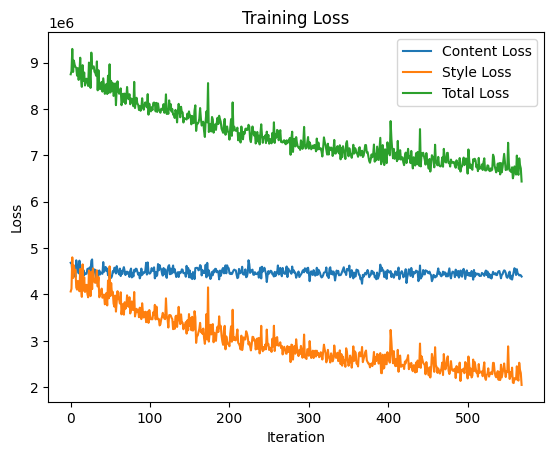

In [ ]:
""" Run this to train the model """
#[NOTE]: For representation purpose i am using a smaller dataset. Pls use the dataset given at the start of this notebook
#for better results and change the dataset_path in this function.

fast_trainer(style_image='./style/picasso_selfportrait.jpg',style_name = 'Picasso_Selfportrait',
             dataset_path = "/content/drive/MyDrive/NST_project/COCO_dataset_17" , epochs = 1)

In [ ]:
!ls -1 "/content/drive/MyDrive/NST_project/COCO_dataset_17" | wc -l
#checks how many images are there in dataset


4550


In [ ]:
import os
print(len(os.listdir("/content/drive/MyDrive/NST_project/COCO_dataset_17")))


4550


Image Saved: ./results/best_model-output.jpg


<ipython-input-35-c71d48022117>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(checkpoint_model, map_location="cpu"))


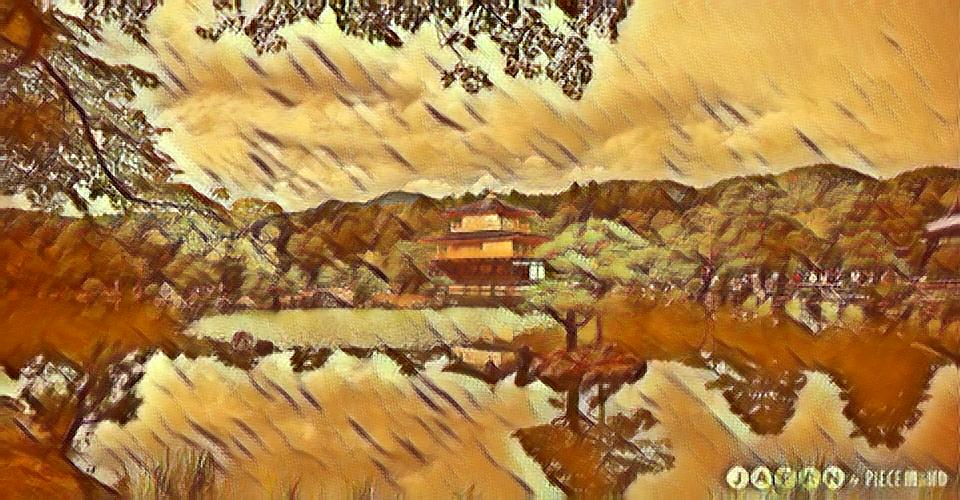

In [ ]:
test_image(image_path = './content/japanese_garden.jpg',
           checkpoint_model = './checkpoints/best_model.pth',
           save_path = './')

In [ ]:
model = TransformerNet()  # Instantiate model


In [ ]:
torch.save(model.state_dict(), "./transformer_net.pth")


In [ ]:
device = torch.device("cpu")  # Force CPU usage
model = TransformerNet()
model.load_state_dict(torch.load("transformer_net.pth", map_location=device))  # Load on CPU
model.eval()  # Set to evaluation mode


<ipython-input-41-5ee3614628c8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transformer_net.pth", map_location=device))  # Load on CPU

TransformerNet(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((4, 4, 4, 4))
        (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      )
      (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Load image
image_path = './content/japanese_garden.jpg'  # Replace with actual image path
image = Image.open(image_path).convert("RGB")

# Transform image to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match training size
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))  # Scale to [0, 255]
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


In [ ]:
with torch.no_grad():  # Disable gradient calculation for inference
    output_tensor = model(input_tensor)

# Convert output back to an image
output_tensor = output_tensor.squeeze(0).clamp(0, 255) / 255  # Normalize
output_image = transforms.ToPILImage()(output_tensor)

# Save or Show Image
output_image.save("stylized_image.jpg")  # Save output
output_image.show()  # Show output


In [ ]:
output = output.squeeze(0).detach().cpu().numpy()
output = np.clip(output, 0, 255).astype("uint8")


NameError: name 'output' is not defined